# A Two Stage Strategy for Feature Subset Selection
1. Use Permutation Feature Importance to identify a large subset of candidates
2. Use a Wrapper search on this subset to select a final set

## Permutation Feature Importance
https://scikit-learn.org/stable/modules/permutation_importance.html  

This is a good way to score feature importance in the context of a specific classifier/model.  
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.  
The idea comes from the original work on Random Forests by Leo Breiman:  
L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

In [50]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Load the Ionsphere dataset from the UCI repository. 

In [72]:
col_heads = [str(x) for x in range(34)]
col_heads.append('Class')
ion_data = pd.read_csv('ionosphere.csv', names = col_heads, na_values='?', header = None)
ion_data.dropna(axis = 0, inplace = True)
print(ion_data.shape)
ion_data.head()

(351, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,Class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [45]:
y = ion_data.pop('Class').values
X = ion_data
ion_scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = ion_scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    random_state=2, test_size=1/2)

In [46]:
# Final results dataframe
res_df = pd.DataFrame([['All Features',0.0,0.0],
                   ['After PI',0.0,0.0],
                   ['After Wrapper',0.0,0.0]],columns=['Method','X-Val','Hold-Out'])
res_df.set_index('Method', inplace = True)

In [48]:
kNN = KNeighborsClassifier(n_neighbors=3)
kNN = kNN.fit(X_train,y_train)
y_pred = kNN.predict(X_test)
acc = accuracy_score(y_pred,y_test)
cv_acc = cross_val_score(kNN, X_train, y_train, cv=8)

res_df.loc['All Features']['X-Val']=cv_acc.mean()
res_df.loc['All Features']['Hold-Out']=acc

print("X_Val on training all features: {0:.3f}".format(cv_acc.mean())) 
print("Hold Out testing all features: {0:.3f}".format(acc)) 

X_Val on training all features: 0.818
Hold Out testing all features: 0.795


In [15]:
knn_perm = permutation_importance(kNN, X_train, y_train, 
                                n_repeats=10, random_state=0)

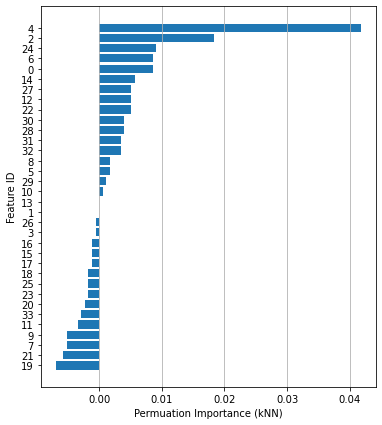

In [71]:
sorted_idx = knn_perm.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(6, 7))
ax.barh(ion_data.columns[sorted_idx], knn_perm.importances_mean[sorted_idx], zorder=1)
ax.xaxis.grid(True)
ax.set_ylabel("Feature ID")
ax.set_xlabel("Permuation Importance (kNN)");
ax.figure.savefig("PIscores.png")


In [17]:
mask = knn_perm.importances_mean[sorted_idx]>0

In [18]:
PI_features = ion_data.columns[sorted_idx][mask]

In [19]:
X_PI = X[PI_features]
print("Permutation Importance selects", X_PI.shape[1], "features.")
X_PI_scaled = preprocessing.MinMaxScaler().fit_transform(X_PI)
X_PI_train, X_PI_test, y_PI_train, y_PI_test = train_test_split(X_PI_scaled, 
                                                                   y, random_state=2, 
                                                                   test_size=1/2)

Permutation Importance selects 18 features.


In [52]:
knnPI = KNeighborsClassifier(n_neighbors=3)
knnPI = knnPI.fit(X_PI_train,y_PI_train)

y_pred_PI = knnPI.predict(X_PI_test)
acc_PI = accuracy_score(y_pred_PI,y_test)
cv_acc_PI = cross_val_score(knnPI, X_PI_train, y_train, cv=8)

res_df.loc['After PI']['X-Val']=cv_acc_PI.mean()
res_df.loc['After PI']['Hold-Out']=acc_PI


print("X_Val on training all features: {0:.3f}".format(cv_acc_PI.mean())) 
print("Hold Out testing all features: {0:.3f}".format(acc_PI)) 

X_Val on training all features: 0.880
Hold Out testing all features: 0.847


## Wrapper

In [34]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select='auto', direction = 'backward',
                                cv = 10, tol = 0.00001
                               )
sfs.fit(X_PI_train, y_train)
X_PI_W_train = sfs.transform(X_PI_train)
X_PI_W_test = sfs.transform(X_PI_test)

In [35]:
knnPIW = KNeighborsClassifier(n_neighbors=3)
knnPIW = knnPIW.fit(X_PI_W_train,y_PI_train)
print(X_PI_W_train.shape)
knnPIW.score(X_PI_W_test,y_PI_test)

(175, 16)


0.8465909090909091

In [55]:
knnPIW = KNeighborsClassifier(n_neighbors=3)
knnPIW = knnPIW.fit(X_PI_W_train,y_PI_train)
print(X_PI_W_train.shape)

y_pred_PIW = knnPIW.predict(X_PI_W_test)
acc_PIW = accuracy_score(y_pred_PIW,y_PI_test)
cv_acc_PIW = cross_val_score(knnPIW, X_PI_W_train, y_train, cv=8)

res_df.loc['After Wrapper']['X-Val']=cv_acc_PIW.mean()
res_df.loc['After Wrapper']['Hold-Out']=acc_PIW


print("X_Val on training all features: {0:.3f}".format(cv_acc_PIW.mean())) 
print("Hold Out testing all features: {0:.3f}".format(acc_PIW)) 

(175, 16)
X_Val on training all features: 0.897
Hold Out testing all features: 0.847


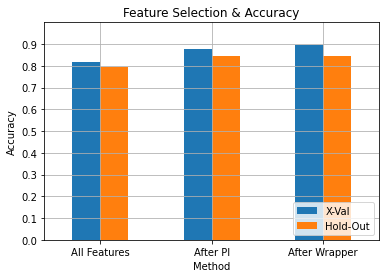

In [69]:
ax = res_df.plot.bar(rot=0)
ax.set_ylabel("Accuracy")
ax.set_title("Feature Selection & Accuracy")
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1,0.1))
ax.legend(loc='lower right')
ax.grid(True)
ax.figure.savefig("PI+Wrapper.png")
